In [1]:
!pip install -q transformers==4.37.2 --quiet
!pip install pydot --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 33.1 MB/s eta 0:00:00


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, AutoModel
import torch
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

import os
from google.colab import drive

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
#Mount GDrieve and go to the main project folder
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/w266_project')


Mounted at /content/drive


In [4]:
#Read the data
df = pd.read_csv("features.csv", header = 0, sep="\t", index_col=0)

In [5]:
# Load SciBERT tokenizer and model
model_checkpoint = "allenai/scibert_scivocab_uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint, from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [6]:
# Reduce the sparcity of the Aut country vector by lumping togther all bu the biggest countries
big_countries = ['USA', 'Germany' 'Japan', 'Sweden', 'UK', 'Canada', 'Italy', 'Switzerland', 'France', 'China', 'Belgium', 'Netherlands', 'Australia', 'Spain',
'Poland', 'Austria', 'Denmark', 'Hungary','India','Finland','Taiwan', 'South Korea','Russia' ,'Czech Rep.']

df['Auth_country'] = df['Auth_country'].apply(lambda x: x if x in big_countries else 'other')

In [7]:
# Add title and abstract togther
df['Abstract'] = df['Document Title'] + df['Abstract']

In [8]:
# Get the data frame only with columns we will need
X = df[['JIF','Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words', 'Funding','Auth_country', 'Pub_country', 'Abstract']]

#Get the indeces to split train and test
train_idx, val_idx, y_train, y_val = train_test_split(range(len(df)), df['JIF'], test_size=0.3, random_state=42)

### Augment training data

In [9]:
#Get the trainin data
X_train = df.iloc[train_idx]

#Sort it by JIF
X_train.sort_values('JIF', inplace = True)

#Make an empty starter dataframe
X_train_aug = pd.DataFrame(columns = X_train.columns)

#Gor each abstract replace n'th sentence with n'th sentense of the abstracts before and after
for i in range(1, len(X_train)-1):
    # Display the number of the record we are working on
    if i%20 ==0:
        end = '\n'
    else:
        end = ', '
    print(i, end = end)

    # Get the handles for the curret record, the one before an dthe one after
    lst_Abs = []
    Abstracts = {}
    Abstracts['before'] = nltk.sent_tokenize(str(X_train['Abstract'].iloc[i-1]))
    Abstracts['this'] = nltk.sent_tokenize(str(X_train['Abstract'].iloc[i]))
    Abstracts['after'] = nltk.sent_tokenize(str(X_train['Abstract'].iloc[i+1]))
    shortest_abs_len = min(len(Abstracts['before']), len(Abstracts['this']), len(Abstracts['after']))

    # Generate new abstracts by replacing n-th sentense with
    # n-th sentense of the abstract before and after
    lst_Abs.append(' '.join(Abstracts['this']))
    for k in range(shortest_abs_len):
        to_augment = Abstracts['this'].copy()
        to_augment[k] = Abstracts['before'][k]
        lst_Abs.append(' '.join(to_augment))

        to_augment[k] = Abstracts['after'][k]
        lst_Abs.append(' '.join(to_augment))

    # For features other than abstract, generate list of values all with the values of the record we are augmenting
    new_entries_dic = {}
    for col in df.columns:
        if col == 'Abstract':
            pass
        else:
            new_entries_dic[col] = [X_train[col].iloc[i] for x in range(len(lst_Abs))]
    new_entries_dic['Abstract'] = lst_Abs

    #Concatenate the augmented abstracts to the new dataframe
    X_train_aug= pd.concat( [X_train_aug, pd.DataFrame(new_entries_dic)], axis=0, ignore_index = True)


<ipython-input-9-92c9b7a9b627>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.sort_values('JIF', inplace = True)


1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40
41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60
61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80
81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100
101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120
121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140
141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160
161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180
181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200
201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220
221, 222, 223, 224,

In [10]:
# Shuffle training set
print("Shuffling training dataset ....")
num_val = len(X_train_aug)
indices = np.arange(num_val)
shuffled_indices = np.random.permutation(indices)
X_train_aug = X_train_aug.iloc[shuffled_indices]
print(f"{len(X_train_aug)}")

Shuffling training dataset ....
48639


In [11]:
# Combine augmented training and non-augmented validation data to do one-hot encoding and scaling
X_combined = pd.concat([X_train_aug, X.iloc[val_idx]], axis = 0).reset_index()

# Prepare one-hot encoded data for both train and validation
categories = ['Funding','Auth_country', 'Pub_country']
val_one_hot_data = {}
train_one_hot_data = {}
for cat in categories:
  one_hot_df = pd.get_dummies(X_combined[cat], prefix=cat, dtype=int)
  train_one_hot_data[cat] = one_hot_df.iloc[ X_combined[X_combined.index < len(X_train_aug)].index   ]
  val_one_hot_data[cat] = one_hot_df.iloc[X_combined[X_combined.index >= len(X_train_aug)].index]

# Scale numerical data for both train and validation
num_data = X_combined[['Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words']]
scaler  = MinMaxScaler(feature_range=(0,1))
num_data = scaler.fit_transform(num_data)
train_num_data = num_data[range(len(X_train_aug))]
val_num_data = num_data[range(len(X_train_aug), len(X_combined))]

In [12]:
# Make target variables
y_train = X_combined[['JIF']].iloc[ X_combined[X_combined.index < len(X_train_aug)].index   ]
y_val = X_combined[['JIF']].iloc[X_combined[X_combined.index >= len(X_train_aug)].index]
y_val = np.array(y_val['JIF'])

### Model with text and metadata

In [13]:
max_length = 400
train_encodings = bert_tokenizer(list(X_train_aug['Abstract']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
val_encodings = bert_tokenizer(list(X['Abstract'].iloc[val_idx]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [14]:
hidden_size = 768 + 5 + 49 + 10 + 1
dropout = 0.3
bert_model.trainable = False
learning_rate = 0.0001

num_of_levels  = df['Funding'].nunique()
#Jeremy Howard provides the following rule of thumb; embedding size = min(50, number of categories/2).
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Funding embeding size: {embedding_size}')

fund_input = keras.layers.Input(shape=(num_of_levels,), name = 'fund_input')
fund_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'fund_emb')(fund_input)
fund_emb = tf.keras.layers.Dropout(dropout)(fund_emb)
fund_flat = keras.layers.Flatten(name = 'fund_flat')(fund_emb)

num_of_levels  = df['Auth_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Auth cont embeding size: {embedding_size}')

Auth_input = keras.layers.Input(shape=(num_of_levels,), name = 'Auth_input')
Auth_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Auth_emb')(Auth_input)
Auth_emb = tf.keras.layers.Dropout(dropout)(Auth_emb)
Auth_flat = keras.layers.Flatten(name = 'Auth_flat')(Auth_emb)

num_of_levels  = df['Pub_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Pub cont embeding size: {embedding_size}')

Pub_input = keras.layers.Input(shape=(num_of_levels,), name = 'Pub_input')
Pub_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Pub_emb')(Pub_input)
Pub_emb = tf.keras.layers.Dropout(dropout)(Pub_emb)
Pub_flat = keras.layers.Flatten(name = 'Pub_flat')(Pub_emb)

inp_num_data = keras.layers.Input(shape=(num_data.shape[1],), name = 'Num feat')

bert_model.trainable = False

input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

bert_inputs = {'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask}

bert_out = bert_model(bert_inputs)

token = bert_out[0][:, 0, :] #cls token

# Concatenate all layers
conc = keras.layers.Concatenate()([token, Auth_flat, Pub_flat, fund_flat, inp_num_data])

hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(conc)
hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)

# Create output layer
out = keras.layers.Dense(1, activation='linear', name = 'Regression_layer')(hidden1)
model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask,
                            Auth_input, Pub_input, fund_input,
                            inp_num_data], outputs=out)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
model.summary()

Funding embeding size: 1
Auth cont embeding size: 12
Pub cont embeding size: 10
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Auth_input (InputLayer)     [(None, 23)]                 0         []                            
                                                                                                  
 Pub_input (InputLayer)      [(None, 20)]                 0         []                            
                                                                                                  
 fund_input (InputLayer)     [(None, 2)]                  0         []                            
                                                                                                  
 attention_mask_layer (Inpu  [(None, 400)]                0         []                            
 tLayer)      

In [15]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

model.fit([ train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask,
           train_one_hot_data['Auth_country'], train_one_hot_data['Pub_country'], train_one_hot_data['Funding'],
           train_num_data],
           y_train,
           validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                            val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'], val_one_hot_data['Funding'],
                            val_num_data],
                            y_val),
           batch_size=128, epochs=60, callbacks=[early_stopping])

Epoch 1/60
380/380 [==============================] - 496s 1s/step - loss: 4.0407 - mean_squared_error: 4.0407 - val_loss: 3.1185 - val_mean_squared_error: 3.1185
Epoch 2/60
380/380 [==============================] - 477s 1s/step - loss: 3.0491 - mean_squared_error: 3.0491 - val_loss: 2.8976 - val_mean_squared_error: 2.8976
Epoch 3/60
380/380 [==============================] - 478s 1s/step - loss: 2.7399 - mean_squared_error: 2.7399 - val_loss: 2.7572 - val_mean_squared_error: 2.7572
Epoch 4/60
380/380 [==============================] - 478s 1s/step - loss: 2.5377 - mean_squared_error: 2.5377 - val_loss: 2.6659 - val_mean_squared_error: 2.6659
Epoch 5/60
380/380 [==============================] - 477s 1s/step - loss: 2.3568 - mean_squared_error: 2.3568 - val_loss: 2.5945 - val_mean_squared_error: 2.5945
Epoch 6/60
380/380 [==============================] - 478s 1s/step - loss: 2.1887 - mean_squared_error: 2.1887 - val_loss: 2.5419 - val_mean_squared_error: 2.5419
Epoch 7/60
380/380 [==

In [16]:
pred = model.predict([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                      val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'], val_one_hot_data['Funding'],
                      val_num_data])

43/43 [==============================] - 15s 290ms/step


Text(0, 0.5, 'Observed')

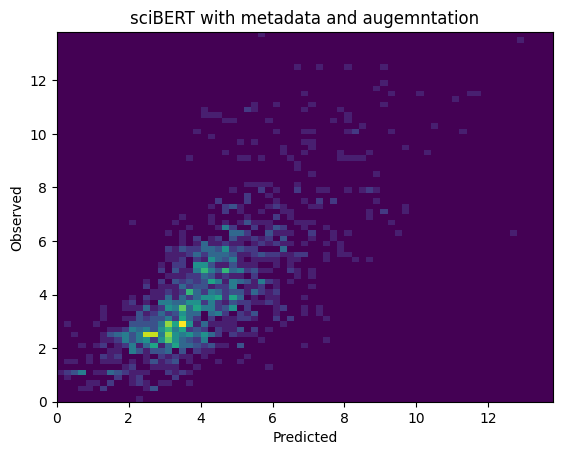

In [17]:
predictions = pred.reshape((-1))
fig, ax = plt.subplots()
ax.hist2d(predictions, y_val , bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_title('sciBERT with metadata and augemntation')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')

In [21]:
np.corrcoef(predictions, y_val)

array([[1.        , 0.72921812],
       [0.72921812, 1.        ]])

In [19]:

#Save predictions only
df_to_save = pd.DataFrame({'Observed':y_val, 'Predicted':predictions})
p = os.path.abspath('.')
file_path = os.path.join(p, 'results_csv', 'scibert_aug_new.csv')
df_to_save.to_csv(file_path, sep = '\t')

In [20]:

#Save predictions only
df_to_save = df.iloc[val_idx]
df_to_save['Predicted'] = predictions
p = os.path.abspath('.')
file_path = os.path.join(p, 'results_csv', 'scibert_aug_full_df.csv')
df_to_save.to_csv(file_path, sep = '\t')

<ipython-input-20-b518610d63bb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_save['Predicted'] = predictions


In [22]:
np.corrcoef(df_to_save['Predicted'], df_to_save['JIF'])

array([[1.        , 0.72921812],
       [0.72921812, 1.        ]])